In [25]:
import re
import tweepy
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
import unicodedata

Para iniciarmos este artigo é necessário que você realize três passos simples:

1. Instalar o pacote [tweepy](https://docs.tweepy.org/en/stable/) que simplifica o consumo das APIs do Twitter, utilizando o comando `pip install tweepy`.
2. No Twitter, além de ter uma conta ativa, ativar seu cadastro como desenvolvedor através deste [link](https://developer.twitter.com/en/portal/dashboard)
3. Após atualizar sua conta para o modo desenvolvedor é necessário solicitar a elevação das permissões de acesso, já que as permissões iniciais não são suficientes para a utilização da API. Isso pode ser feito no próprio site do [Twitter Developer](https://developer.twitter.com/en/portal/dashboard)

Uma vez que estes passos foram executados é necessário copiar as chaves de autenticação geradas pelo próprio Twitter, você pode fazer isso na página do projeto criado no [Twitter Developer](https://developer.twitter.com/en/portal/dashboard)

![title](img/chaves_twitter.png)

Conexão com API Twitter

In [59]:
def twitter_authentication(consumer_key: str, consumer_secret: str, access_token: str, access_token_secret: str):
    api = None
    try:
        auth = tweepy.OAuthHandler(consumer_key, consumer_secret)
        auth.set_access_token(access_token, access_token_secret)
        # o comando wait_on_rate_limit evita que suas requisições sejam identificadas erroneamente como uso abusivo
        api = tweepy.API(auth, wait_on_rate_limit = True)

        return api
    except:
        print('Error')
        return False

Método para limpeza de caracteres especiais

In [54]:
def clean_tweet(tweet: str):
    return ''.join(ch for ch in unicodedata.normalize('NFKD', tweet) if not unicodedata.combining(ch))

Análise de sentimento do tweet, usando o método `SentimentIntensityAnalyzer` do pacote `nltk`

In [69]:
#create stopwords base
stopwords = nltk.corpus.stopwords.words("english")

def get_tweet_sentiment(tweet: str) -> dict:
    # remove stop words
    processed_tweet = clean_tweet(tweet)
    processed_tweet = ' '.join([w for w in re.split("\W+", processed_tweet) if processed_tweet.lower() not in stopwords])
    sia = SentimentIntensityAnalyzer()
    sia_result = sia.polarity_scores(processed_tweet)
    overall_result = ''
    if sia_result['pos'] > sia_result['neu'] and sia_result['pos'] > sia_result['neu']: 
        overall_result = 'positive'
    elif sia_result['neg'] > sia_result['neu'] and sia_result['neg'] > sia_result['pos']: 
        overall_result = 'negative'
    else:
        overall_result = 'neutral'
    return {
        'processed_tweet': processed_tweet,
        'positive': str(sia_result['pos']),
        'neutral': str(sia_result['neu']),
        'negative': str(sia_result['neg']),
        'overall_result': overall_result
    }
    

Leitura dos tweets com base nas palavras chave informadas, ele irá retornar uma lista com as informações de cada tweet encontrado

Este método também fará a chamada o método responsávep pela análise de sentimento.

In [70]:
def get_tweets(api, search_words, count: int) -> list:
    tweets = []

    fetched_tweets = tweepy.Cursor(
        api.search_tweets, 
        search_words,
        lang="en"
    ).items(count)

    for tweet in fetched_tweets:
        parsed_tweet = {}
        parsed_tweet['tweet'] = tweet.text
        parsed_tweet['tweet_date'] = tweet.created_at        
        sentiment = get_tweet_sentiment(tweet.text)
        parsed_tweet['processed_tweet'] = sentiment['processed_tweet']
        parsed_tweet['sentiment'] = sentiment['overall_result']
        parsed_tweet['perc_positive'] = sentiment['positive']
        parsed_tweet['perc_neutral'] = sentiment['neutral']
        parsed_tweet['perc_negative'] = sentiment['negative']
        parsed_tweet['user_name'] = tweet.user.screen_name
        parsed_tweet['profile_creation'] = tweet.user.created_at
        parsed_tweet['followers_count'] = tweet.user.followers_count        
        if tweet.retweet_count > 0:
            if parsed_tweet not in tweets:
                tweets.append(parsed_tweet)
        else:
            tweets.append(parsed_tweet)
    return tweets

Execução da análise.

`Cuidado com a quantidade informada no parâmetro count, colocar um número muito grande de tweets pode bloquear seu acesso`

In [71]:
api = twitter_authentication(
    consumer_key = 'zZRAdl7a4qcc... ',
    consumer_secret = 'oW3SVv6D9Qhi8... ',
    access_token = '11233536942868... ',
    access_token_secret = 'tQ476g60jUOFm...')

tweets = get_tweets(
    api, ["Star Wars"], 
    count = 1000
)

Rate limit reached. Sleeping for: 208


Este foi o resultado da execução

![title](img/dataset.jpg)

Os métodos abaixo farão uma análise simples sobreo resultado da anális de sentimento

In [72]:
def classify_emotions_in_percentage(tweets: list) -> dict:
    sentiment_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'positive']
    positive_tweets_percentage = ((len(sentiment_tweets) / len(tweets)) * 100)

    sentiment_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'negative']
    negative_tweets_percentage = ((len(sentiment_tweets) / len(tweets)) * 100)    

    sentiment_tweets = [tweet for tweet in tweets if tweet['sentiment'] == 'neutral']    
    neutral_tweets_percentage = ((len(sentiment_tweets) / len(tweets)) * 100)    

    print("Tweets percentage")
    print(f'  Positive: {positive_tweets_percentage}')
    print(f'  Neutral: {neutral_tweets_percentage}')    
    print(f'  Negative: {negative_tweets_percentage}')

    return {'Positive': positive_tweets_percentage, 'Neutral': neutral_tweets_percentage, 'Negative': negative_tweets_percentage}

Tweets percentage
  Positive: 0.5
  Neutral: 98.0
  Negative: 1.5


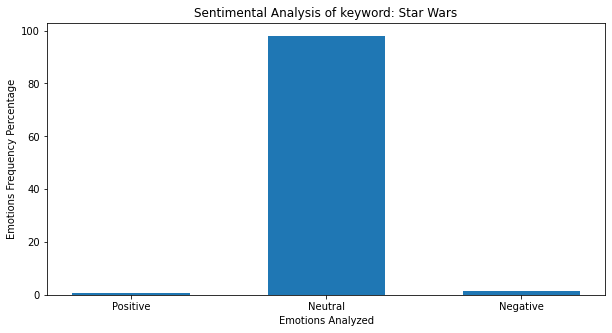

In [73]:
def visualize_data(data: dict, keyword: str):
    emotions = list(data.keys())
    percentage = list(data.values())

    fig = plt.figure(figsize= (10,5))
    plt.bar(emotions, percentage, width = .6)
    plt.xlabel('Emotions Analyzed')
    plt.ylabel('Emotions Frequency Percentage')
    plt.title(f'Sentimental Analysis of keyword: {keyword}')
    plt.show()

visualize_data(
    data = classify_emotions_in_percentage(tweets), 
    keyword= 'Star Wars'
)